# Lab08 - Neural Networks and Deep Learning
Author: [Yunting Chiu](https://www.linkedin.com/in/yuntingchiu/) adapted from Dr. Zois Boukouvalas

# Install the required packages

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# Exercise 1
This exercise focuses on the original GAN, which is trained on the MNIST database to learn
to generate artificial hand-written characters. To implement and train the network, use the
TensorFlow framework. You are encouraged to use the Keras high-level API for simplicity.

(a) Load the data set of 60000 to be used for training. Normalize image values so that all
values are in the $[−1, 1]$ interval. In Keras, you may use the functions provided by the
`tensorflow.keras.datasets.mnist` module.

In [3]:
# to make sure we have the same results for each time
np.random.seed(1234)

In [4]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalize the inputs to be in the range[-1, 1]
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
# convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have 784 columns pre row
x_train = x_train.reshape(60000, 784)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 28, 28)
(60000,)
(10000,)


In [5]:
def load_MINST():
  # load the data
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  # normalize our inputs to be in the range[-1, 1]
  x_train = (x_train.astype(np.float32) - 127.5)/127.5
  # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
  # 784 columns per row
  x_train = x_train.reshape(60000, 784)
  return (x_train, y_train, x_test, y_test)

(b) The generator is fed to its input with a noise vector and outputs an image. The dimension
of the input noise vector is 100, and its elements are i.i.d. sampled from a normal distribution of zero mean and unit variance. The generator consists of three fully connected
layers with 256, 512, and 1024 neurons, respectively. The activation function used for the
neurons in the hidden layers is the leaky ReLU with parameter α = 0.2. The output layer
comprises 784 nodes and the tanh is employed as the respective activation function.

- Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.

In [6]:
# The dimension of our random noise vector.
random_dim = 100

# We will use the Adam optimizer
def get_optimizer():
  return Adam(lr = 0.0002, beta_1 = 0.5)

In [7]:
def get_generator(optimizer):
  generator = Sequential()
  # 256 neurons
  generator.add(Dense(256, input_dim=random_dim,kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))

  # 512 neurons
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))

  # 1024 neurons
  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(784, activation='tanh'))
  generator.compile(loss='binary_crossentropy', optimizer=optimizer)
  return generator

(c) The discriminator takes as input a 1 × 784 vector, corresponding to the vectorized form
of the 28 × 28 MNIST images. The discriminator consists of three fully connected layers
with 1024, 512, and 256 neurons, respectively. The leaky ReLU activation function is also
employed, with $\alpha$ = 0.2. During training, use the dropout regularization method, with
probability of discarding nodes equal to 0.3. The output layer consist of a single node
with a sigmoid activation function.

In [8]:
def get_discriminator(optimizer):
  discriminator = Sequential()
  discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  # use the dropout regularization method, with probability of discarding nodes equal to 0.3
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))

  discriminator.add(Dense(1, activation='sigmoid'))
  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
  return discriminator

(d) To train the implemented network, use the two-class (binary) cross-entropy loss function.
Adopt the Adam minimizer with step size (learning rate) equal to $2 ×10^{−3}$
, $\beta1$ = 0.5, and
$\beta2$ = 0.999 as parameters for the optimizer. The recommended batch size is 100. Train
the network for 400 epochs as follows. For each training loop, (a) generate a random set
of input noise and images, (b) generate fake images via the generator, (c) train only the
discriminator, and (d) then train only the generator, according to Algorithm 18.5. Play
with the number of iterations, associated with the discriminator training.

In [9]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
  # We initially set trainable to False since we only want to train either the generator or discriminator at a time
  discriminator.trainable = False

  # gan input (noise) will be 100-dimensional vectors
  gan_input = Input(shape=(random_dim,))

  # the output of the generator (an image)
  x = generator(gan_input)
  # get the output of the discriminator (probability if the image is real or not)
  gan_output = discriminator(x)
  gan = Model(inputs=gan_input, outputs=gan_output)
  gan.compile(loss='binary_crossentropy', optimizer=optimizer)
  return gan

In [10]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
  noise = np.random.normal(0, 1, size=[examples, random_dim])
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(examples, 28, 28)
  plt.figure(figsize=figsize)
  for i in range(generated_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
    plt.tight_layout()
  %cd /content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/10/submit
  plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

(e) During training and every 20 epochs, visualize the generated images created by the generator and comment on the evolution of the learning process.

In [11]:
def train(epochs=1, batch_size=128):
  # Get the training and testing data
  x_train, y_train, x_test, y_test = load_MINST()
  # Split the training data into batches of size 128
  batch_count = x_train.shape[0] / batch_size

  # Build the GAN netowrk
  adam = get_optimizer()
  generator = get_generator(adam)
  discriminator = get_discriminator(adam)
  gan = get_gan_network(discriminator, random_dim, generator, adam)
  for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(0, int(batch_count))):
      # Get a random set of input noise and images
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
      # Generate fake MNIST images
      generated_images = generator.predict(noise)
      X = np.concatenate([image_batch, generated_images])
      # Labels for generated and real data
      y_dis = np.zeros(2*batch_size)
      # One-sided label smoothing
      y_dis[:batch_size] = 0.9
      3
      # Train discriminator
      discriminator.trainable = True
      discriminator.train_on_batch(X, y_dis)
      # Train generat or
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      y_gen = np.ones(batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y_gen)
    if e == 1 or e % 20 == 0:
      plot_generated_images(e, generator)

(f) Play with all the various parameters that have been suggested above and see the effect on
the training.
- According to the question, the recommended batch size is 100. Train the network for 400 epochs as follows.
- Iterations is the number of batches needed to complete one epoch. Note: The number of batches is equal to number of iterations for one epoch. We can divide the dataset of 2000 examples into batches of 500 then it will take 4 iterations to complete 1 epoch.
- We can see if the higher the epoch number, the clearer the image output. After epoch 180, We can easily distinguish digit numbers from our eyes.
- iteration= (total observation/batch_size). That is, 60000/100 = 600 iterations to complete 1 epoch.

In [19]:
if __name__ == '__main__':
  train(epochs=400, batch_size=100)

Output hidden; open in https://colab.research.google.com to view.

We have 60000 observations. We should try to increase the number of iteration in order to get better results. However, in order to save the computation time, I will should the bad result below.

In [12]:
x_train.shape[0]

60000

- iteration = (total observation/batch_size). That is, 60000/10000 = 6 iterations to complete 1 epoch.

- We can see the example below, if the number of batch size is big, the model cannot be trained well. In this example, the model only have six iterations in every single epoch. 

- Ideally, batch size of 32, 64, 128, 256 are good start points.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 1 ---------------


100%|██████████| 6/6 [00:39<00:00,  6.54s/it]


/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/10/submit
--------------- Epoch 2 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


--------------- Epoch 3 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


--------------- Epoch 4 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 5 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


--------------- Epoch 6 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.20s/it]


--------------- Epoch 7 ---------------


100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


--------------- Epoch 8 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


--------------- Epoch 9 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 10 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 11 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


--------------- Epoch 12 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


--------------- Epoch 13 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


--------------- Epoch 14 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.33s/it]


--------------- Epoch 15 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


--------------- Epoch 16 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


--------------- Epoch 17 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


--------------- Epoch 18 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 19 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


--------------- Epoch 20 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/10/submit
--------------- Epoch 21 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


--------------- Epoch 22 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


--------------- Epoch 23 ---------------


100%|██████████| 6/6 [00:38<00:00,  6.34s/it]


--------------- Epoch 24 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


--------------- Epoch 25 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


--------------- Epoch 26 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 27 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


--------------- Epoch 28 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 29 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


--------------- Epoch 30 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


--------------- Epoch 31 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 32 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


--------------- Epoch 33 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


--------------- Epoch 34 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


--------------- Epoch 35 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.31s/it]


--------------- Epoch 36 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


--------------- Epoch 37 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 38 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.20s/it]


--------------- Epoch 39 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.19s/it]


--------------- Epoch 40 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/10/submit
--------------- Epoch 41 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


--------------- Epoch 42 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 43 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 44 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


--------------- Epoch 45 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 46 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


--------------- Epoch 47 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


--------------- Epoch 48 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


--------------- Epoch 49 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


--------------- Epoch 50 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


--------------- Epoch 51 ---------------


100%|██████████| 6/6 [00:36<00:00,  6.14s/it]


--------------- Epoch 52 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 53 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


--------------- Epoch 54 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.19s/it]


--------------- Epoch 55 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


--------------- Epoch 56 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


--------------- Epoch 57 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 58 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 59 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.18s/it]


--------------- Epoch 60 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.19s/it]


/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/10/submit
--------------- Epoch 61 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.20s/it]


--------------- Epoch 62 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


--------------- Epoch 63 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


--------------- Epoch 64 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 65 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


--------------- Epoch 66 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


--------------- Epoch 67 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


--------------- Epoch 68 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


--------------- Epoch 69 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 70 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


--------------- Epoch 71 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.21s/it]


--------------- Epoch 72 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


--------------- Epoch 73 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 74 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 75 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.19s/it]


--------------- Epoch 76 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


--------------- Epoch 77 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]


--------------- Epoch 78 ---------------


100%|██████████| 6/6 [00:36<00:00,  6.16s/it]


--------------- Epoch 79 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


--------------- Epoch 80 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.23s/it]


/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/10/submit
--------------- Epoch 81 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


--------------- Epoch 82 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


--------------- Epoch 83 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


--------------- Epoch 84 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


--------------- Epoch 85 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


--------------- Epoch 86 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 87 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.22s/it]


--------------- Epoch 88 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


--------------- Epoch 89 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.20s/it]


--------------- Epoch 90 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 91 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.24s/it]


--------------- Epoch 92 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


--------------- Epoch 93 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 94 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.30s/it]


--------------- Epoch 95 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


--------------- Epoch 96 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.25s/it]


--------------- Epoch 97 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.27s/it]


--------------- Epoch 98 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.32s/it]


--------------- Epoch 99 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


--------------- Epoch 100 ---------------


100%|██████████| 6/6 [00:37<00:00,  6.29s/it]


/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/10/submit


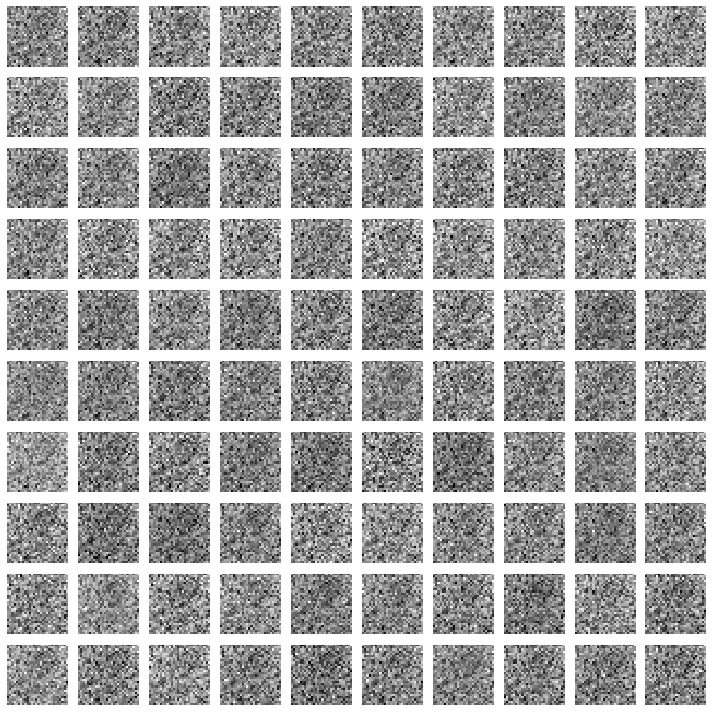

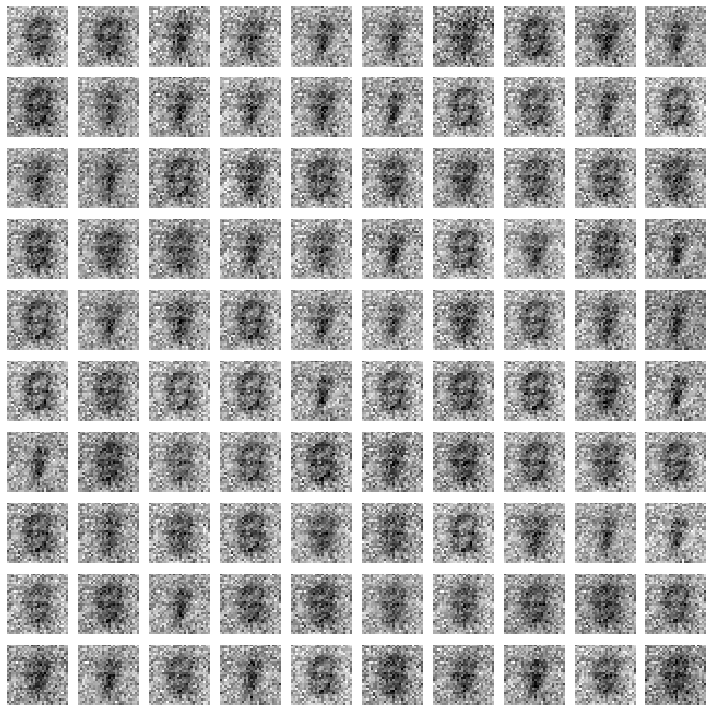

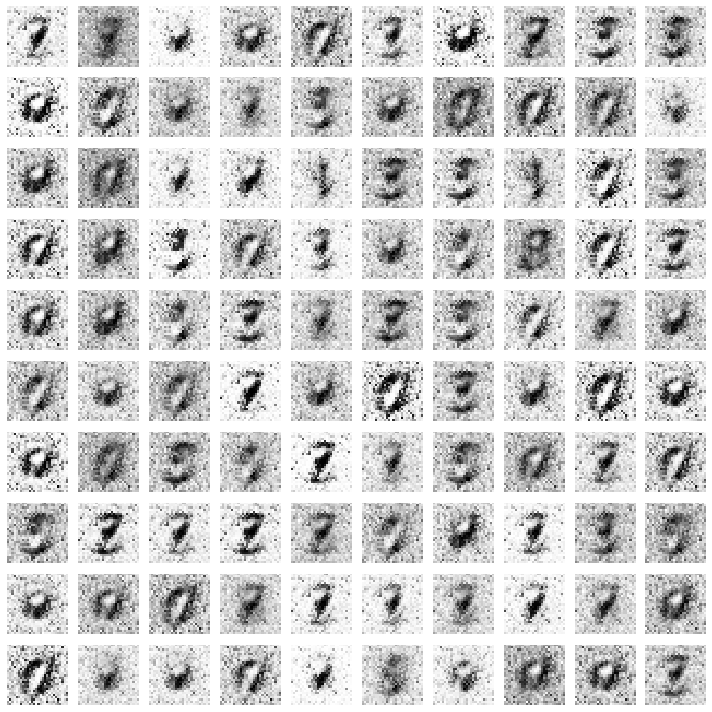

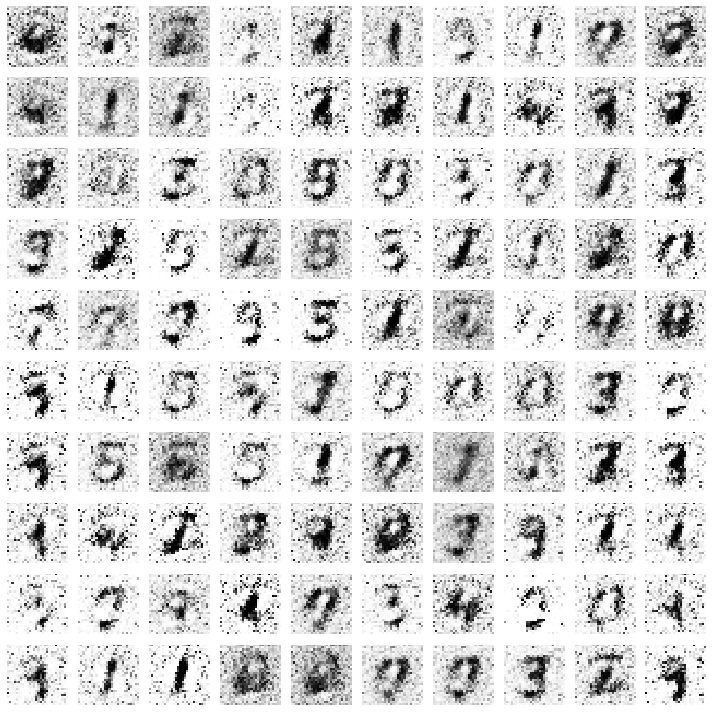

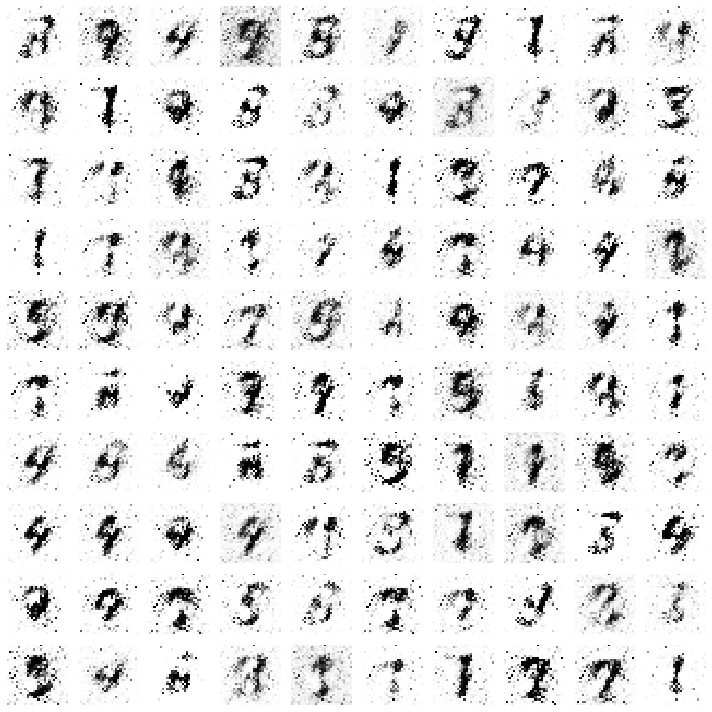

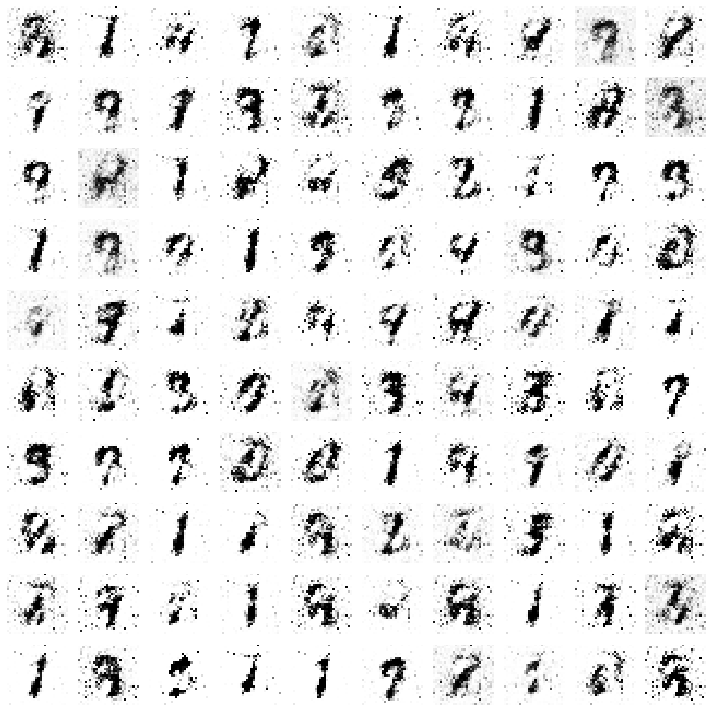

In [16]:
if __name__ == '__main__':
  train(epochs=100, batch_size=10000)

We must use activation functions such as ReLu, sigmoid and tanh in order to add a **non-linear** property to the neural network. In this way, the network can model more complex relationships and patterns in the data.

# References
- https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20a%20replacement%20optimization,sparse%20gradients%20on%20noisy%20problems.
- https://towardsdatascience.com/activation-functions-in-deep-neural-networks-aae2a598f211
- https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

# Output

In [20]:
# should access the Google Drive files before running the chunk
%%capture
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic 
!jupyter nbconvert --to pdf "/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/10/submit/Lab10_Yunting.ipynb"